## Train an image classification model on YData and deploy it on Azure Container Instance (ACI)

In this tutorial, you train a machine learning model on YData and then deploy it on Azure.

This tutorial trains a simple logistic regression modelusing the [MNIST](https://azure.microsoft.com/services/open-datasets/catalog/mnist/) dataset and [scikit-learn](http://scikit-learn.org) with Azure Machine Learning.  MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of 28x28 pixels, representing a number from 0 to 9. The goal is to create a multi-class classifier to identify the digit a given image represents. 

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train and pickle a simple logistic regression model using YData
> * Review training results
> * Set up your testing environment on ACI
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [23]:
!pip install azureml-sdk scikit-learn==0.22.1 pandas numpy matplotlib

### Connect to workspace

Download your Azure Workspace configuration file and upload it in this working directory - It will be used to remotely access your Azure Workspace from YData

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [24]:
from azureml.core import Workspace
ws_other_environment = Workspace.from_config(path="./config.json")

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.34.0


### Load workspace configuration from the config.json file in the current folder

In [26]:
ws = ws_other_environment
print(ws.name, ws.location, ws.resource_group, sep='\t')

azureml-demo	eastus2	demo


### Load data

Load the test data from the **./data/mnist** directory

In [27]:
import numpy as np
import argparse
import os
from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run

import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


data_folder = os.path.join(os.getcwd(), 'data/mnist')

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data("{}/train-images-idx3-ubyte.gz".format(data_folder), False) / 255.0
X_test = load_data("{}/t10k-images-idx3-ubyte.gz".format(data_folder), False) / 255.0
y_train = load_data("{}/train-labels-idx1-ubyte.gz".format(data_folder), True).reshape(-1)
y_test = load_data("{}/t10k-labels-idx1-ubyte.gz".format(data_folder), True).reshape(-1)
print("X_train Shape: {}\ny_train Shape: {}\nX_test Shape: {}\ny_test Shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


X_train Shape: (60000, 784)
y_train Shape: (60000,)
X_test Shape: (10000, 784)
y_test Shape: (10000,)


### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

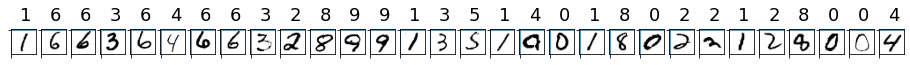

In [28]:
# make sure utils.py is in the same directory as this code
# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Train the Logistic Regression Model

In [29]:
print('Train a logistic regression model with regularization rate of', 0.5)
clf = LogisticRegression(C=1.0/0.5, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

Train a logistic regression model with regularization rate of 0.5
Predict the test set
Accuracy is 0.9193


### Package (pickle) and save the model

In [30]:
joblib.dump(value=clf, filename='./sklearn_mnist_model.pkl')

['./sklearn_mnist_model.pkl']

### Register the model on Azure

In [36]:
from azureml.core import Workspace
ws = ws_other_environment

from azureml.core.model import Model

model_name = "sklearn_mnist"
model = Model.register(model_path="sklearn_mnist_model.pkl",
                        model_name=model_name,
                        tags={"data": "mnist", "model": "classification"},
                        description="Mnist handwriting recognition",
                        workspace=ws)

Registering model sklearn_mnist


### Prepare the Deployment Environment on Azure

In [37]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace = ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210806.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "tutorial-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
 

## Deploy as web service

Deploy the model as a web service hosted in ACI. 

To build the correct environment for ACI, provide the following:
* A scoring script to show how to use the model
* A configuration file to build the ACI
* The model you trained before

### Create scoring script

Create the scoring script, called score.py, used by the web service call to show how to use the model.
Note that this script will be run directly on ACI, and not here on YData

You must include two required functions into the scoring script:
* The `init()` function, which typically loads the model into a global object on Azure. This function is run only once when the Docker container is started. 

* The `run(input_data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported. This is the function that will be called for each test run


In [38]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
import joblib

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting score.py


### Create configuration file

Create a deployment configuration file and specify the number of CPUs and gigabyte of RAM needed for your ACI container. While it depends on your model, the default of 1 core and 1 gigabyte of RAM is usually sufficient for many models. If you feel you need more later, you would have to recreate the image and redeploy the service.

In [39]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

### Deploy in ACI
Estimated time to complete: **about 2-5 minutes**

Configure the image and deploy. The following code goes through these steps:

1. Create environment object containing dependencies needed by the model using the environment file (`myenv.yml`)
1. Create inference configuration necessary to deploy the model as a web service using:
   * The scoring file (`score.py`)
   * envrionment object created in previous step
1. Deploy the model to the ACI container.
1. Get the web service HTTP endpoint.

In [35]:
%%time
import uuid
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')


myenv = Environment.get(workspace=ws, name="tutorial-env", version="1")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

service_name = 'sklearn-mnist-svc-' + str(uuid.uuid4())[:4]
service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-10-06 12:22:32+00:00 Creating Container Registry if not exists.
2021-10-06 12:22:32+00:00 Registering the environment.
2021-10-06 12:22:35+00:00 Use the existing image.
2021-10-06 12:22:35+00:00 Generating deployment configuration.
2021-10-06 12:22:36+00:00 Submitting deployment to compute.
2021-10-06 12:22:42+00:00 Checking the status of deployment sklearn-mnist-svc-1511..
2021-10-06 12:24:23+00:00 Checking the status of inference endpoint sklearn-mnist-svc-1511.
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 338 ms, sys: 32.5 ms, total: 370 ms
Wall time: 1min 59s


Get the scoring web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [40]:
print(service.scoring_uri)

http://adf77e10-3c0d-4691-8d4c-dfefca8d11e8.eastus2.azurecontainer.io/score


## Test the model


### Load test data

Load the test data from the **./data/mnist** directory

In [41]:
import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data("./data/mnist/t10k-images-idx3-ubyte.gz", False) / 255.0
y_test = load_data("./data/mnist/t10k-labels-idx1-ubyte.gz", True).reshape(-1)

### Predict test data

Feed the test dataset to the model to get predictions.


The following code goes through these steps:
1. Send the data as a JSON array to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

In [42]:
import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

###  Examine the confusion matrix

Generate a confusion matrix to see how many samples from the test set are classified correctly. Notice the mis-classified value for the incorrect predictions.

In [43]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


Use `matplotlib` to display the confusion matrix as a graph. In this graph, the X axis represents the actual values, and the Y axis represents the predicted values. The color in each grid represents the error rate. The lighter the color, the higher the error rate is. For example, many 5's are mis-classified as 3's. Hence you see a bright grid at (5,3).

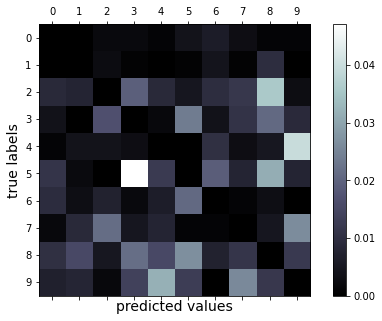

In [37]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

## Show predictions

Test the deployed model with a random sample of 30 images from the test data.  


1. Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples. 

 Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

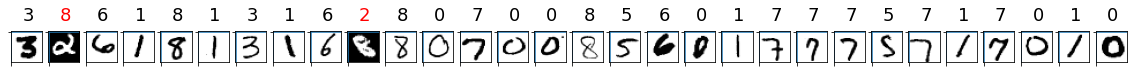

In [38]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

You can also send raw HTTP request to test the web service.

In [39]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://45b26816-f589-4a83-810b-b2537ad6c645.eastus2.azurecontainer.io/score
label: 2
prediction: [2]


## Clean up resources

To keep the resource group and workspace for other tutorials and exploration, you can delete only the ACI deployment using this API call:

In [ ]:
service.delete()